# Load Layer outputs

In [19]:
import pickle
with open('linear_NN_layer_outputs.dat','rb') as f:
    layer_outs,layer_outs_test= pickle.load(f)
f.close()

# Load recording and test data

In [20]:
import numpy as np
from keras.datasets import mnist
from scipy.misc import imresize

(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# Recording data
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

# downsample
factor = 0.25

Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)
    
# VECTORIZE IMAGES
Xtest_down = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down = X_pr_down.reshape(X_pr_down.shape[0], int(xdim*factor)**2).astype('float32') / 255

# Run XGBOOST

In [21]:
from copy import copy, deepcopy
from RE_PartialRecData import RE_PartialRecData
from RE_PartialRecData2 import RE_PartialRecData2
import os
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier
import pickle

params = {}
# use softmax multi-class classification 'multi:softmax'
# use linear regression 'reg:linear'
params['objective'] = 'reg:linear'
# scale weight of positive examples
params['eta'] = 0.5               # Makes the model more robust by shrinking the weights on each step (0.01-0.2)
params['max_depth'] = 5           # Used to control over-fitting as higher depth will allow model to learn relations 
                                  # very specific to a particular sample. (3-10)
#params['max_delta_step']=         # it might help in logistic regression when class is extremely imbalanced.(def=0)
params['silent'] = 1
params['nthread'] = 4
# params['num_class'] = 10
num_round=5

# how many recordings?
nRecordings = 10
# how many neurons from the firs hidden layer?
subnetSize = [2**x for x in range(8)]
#subnetSize =[1, 64, 128]
nSubnetSize = len(subnetSize)
# which layers?
iLayer=2
# how many samples per recording?
nSamples = np.divide(int(X_pr_down.shape[0]/nRecordings),subnetSize)*100
#nSamples =3000
# how many iterations
nIterations = 5

# baseline prediction error
#bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

oLayer = len(layer_outs)-1  # index of output layer
nOutNeurons = layer_outs[oLayer].shape[1]
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])

for ss in range(nSubnetSize):
    #nLayerNeurons = [subnetSize[ss], 0, 0, 0, 10]
    nLayerNeurons = subnetSize[ss]
    print(subnetSize[ss])
    for it in range(nIterations):
        # copy data
        layer_outputs = deepcopy(layer_outs)
        # subsample
#         X_subsample, Y_subsample = RE_PartialRecData(layer_outputs,[subnetSize[ss], 0, 0, 0, 10], 
#                                                      nRecordings, nSamples[ss])
        X_subsample, Y_subsample = RE_PartialRecData2(layer_outputs[iLayer], layer_outputs[oLayer], \
                                                      nLayerNeurons, nRecordings,nSamples[ss])
        #print('# nan neurons: ',np.count_nonzero(np.isnan(X_subsample[:3000,:]).sum(axis=0)))
        # prepare data for xgboost
        for iN in range(nOutNeurons):
            #print('#neuron, #iteratin, subnetsize: ', iN,it,subnetSize[ss])
            xg_train  = xgb.DMatrix(X_subsample, label=Y_subsample[:, iN])
            xg_test   = xgb.DMatrix(layer_outs_test[iLayer], label=layer_outs_test[oLayer][:,iN])
            watchlist = [(xg_train, 'train'), (xg_test, 'test')]
            # train XGboost
            bst = xgb.train(params, xg_train, num_round, watchlist, verbose_eval=False)
            # get predictions
            pred = bst.predict(xg_test)
            rmses[it,iN,ss] = np.sqrt(np.mean(np.square([(pred[i] - layer_outs_test[oLayer][:,iN][i]) 
                                         for i in range(len(layer_outs_test[oLayer][:,1]))])))
        print ('predicting, RMSE=%f' %np.mean(rmses[it, :, ss])

            
# save the rmse's
with open('RMSE_Layer1_NLNN.dat','wb') as f:
    pickle.dump(rmses, f)
f.close()


1
predicting, RMSE=0.253256
predicting, RMSE=0.340534
predicting, RMSE=0.244870
predicting, RMSE=0.252942
predicting, RMSE=0.230431
predicting, RMSE=0.224218
predicting, RMSE=0.253967
predicting, RMSE=0.264015
predicting, RMSE=0.223116
predicting, RMSE=0.208261
predicting, RMSE=0.252564
predicting, RMSE=0.284711
predicting, RMSE=0.238812
predicting, RMSE=0.206918
predicting, RMSE=0.253205
predicting, RMSE=0.212167
predicting, RMSE=0.283270
predicting, RMSE=0.233313
predicting, RMSE=0.219873
predicting, RMSE=0.212583
predicting, RMSE=0.264701
predicting, RMSE=0.327108
predicting, RMSE=0.233118
predicting, RMSE=0.248713
predicting, RMSE=0.241267
predicting, RMSE=0.223377
predicting, RMSE=0.314523
predicting, RMSE=0.238290
predicting, RMSE=0.222919
predicting, RMSE=0.212007
predicting, RMSE=0.259153
predicting, RMSE=0.369794
predicting, RMSE=0.238822
predicting, RMSE=0.245468
predicting, RMSE=0.260418
predicting, RMSE=0.221411
predicting, RMSE=0.280303
predicting, RMSE=0.201676
predicting

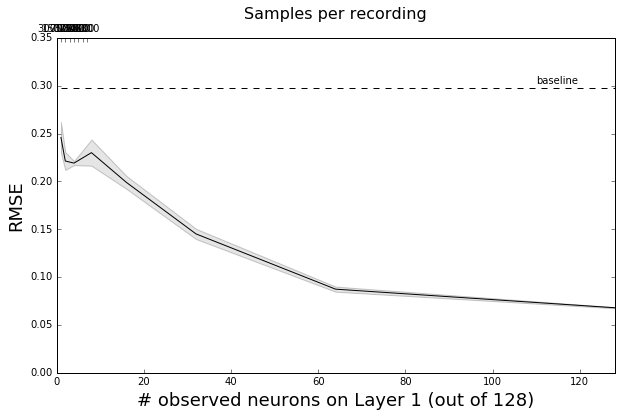

In [18]:

import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

fig=pl.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0, 128])
ax2 = ax1.twiny()

x = subnetSize;
y = np.mean(np.median(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)
bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

pl.plot(x, y, 'k-')
horiz_line_data = np.array([bl for i in xrange(len(x))])
pl.plot(x, horiz_line_data, 'k--') 
pl.fill_between(x, y-error, y+error, alpha=0.2, facecolor='#808080')

ax1.set_xlabel('# observed neurons on Layer 1 (out of 128)', fontsize=18)
ax2.set_xlabel('Samples per recording',  fontsize=16)

new_tick_locations =range(len(nSamples))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(nSamples)


# ax2.set_xticks(nSamples)
# ax2.set_xticklabels(nSamples[range(0, 5, 20)])
ax1.set_ylabel('RMSE', fontsize=18)
ax1.set_ylim([0, .35])

pl.text(110,bl+0.005, 'baseline')


In [11]:

import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

fig=pl.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0, 128])
ax2 = ax1.twiny()

x = subnetSize;
y = np.mean(np.mean(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)
bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

pl.plot(x, y, 'k-')
horiz_line_data = np.array([bl for i in xrange(len(x))])
pl.plot(x, horiz_line_data, 'k--') 
pl.fill_between(x, y-error, y+error, alpha=0.2, facecolor='#808080')

ax1.set_xlabel('# observed neurons on Layer 1 (out of 128)', fontsize=18)
ax2.set_xlabel('Samples per recording',  fontsize=16)

new_tick_locations =range(len(nSamples))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(nSamples)


# ax2.set_xticks(nSamples)
# ax2.set_xticklabels(nSamples[range(0, 5, 20)])
ax1.set_ylabel('RMSE', fontsize=18)
ax1.set_ylim([0, .35])

pl.text(110,bl+0.005, 'baseline')


array([ 0.81443238, -0.11368431,  0.01491976,  0.0562069 ,  0.10324968,
        0.13046996,  0.05343611,  0.00743314,  0.04449047, -1.35253549,
       -0.1250589 , -0.08362171, -0.07016276,  0.08619235,  0.00856998,
        0.01610628, -0.01278366, -0.10750663, -0.07218713,  1.93863451,
       -0.10159225, -0.05058051, -0.08725339,  0.0191335 ,  0.05080027,
        0.00212165, -0.71098471, -0.15693064,  0.2025125 , -0.11888117,
        0.03336797, -0.05832686, -0.63679385, -0.09086666,  0.29607138,
       -0.00593347, -0.08109716, -0.03592174,  0.10771234, -0.40838328,
       -0.01420826,  0.19876496,  0.91541892,  0.00773808, -0.13647176,
        0.02398049, -0.10600544,  0.09192715, -0.07608515,  0.0958133 ,
       -0.03716246, -0.0634966 ,  0.10554523, -0.78309858,  0.05043452,
        0.11540226,  0.02181032,  0.44112802, -0.95387816, -0.07733119,
        0.15069699, -0.06733273, -0.03574334,  0.15238135,  0.04009382,
        0.08564769,  0.1860472 ,  0.00699243, -0.06394672, -0.09